In [1]:
import tensorflow as tf
from tensorflow.compat.v1 import Session

In [2]:
if len(tf.config.experimental.list_physical_devices('GPU')) > 0:
    print("GPU ready to be used")
else:
    print("GPU not in use, check env maybe?")

GPU ready to be used


In [49]:
#!pip install git+https://github.com/qubvel/segmentation_models
#!pip install opencv-python
#!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
#!pip uninstall scikit-image
#!pip install scikit-image

In [3]:
import numpy as np
import random
#np.random.seed(1337)

import tensorflow as tf
import tensorflow.keras.backend as K
print(K.image_data_format()) # verify format is set to channel last
import tensorflow.keras
from tensorflow.keras.callbacks import ModelCheckpoint

import cv2
from PIL import Image

from sklearn.model_selection import train_test_split
from scipy.ndimage import distance_transform_edt as distance

import segmentation_models as sm #https://github.com/qubvel/segmentation_models

import albumentations as A
import image_visualization as visualization
import image_processing as processing
import metrics as metrics

import matplotlib.pyplot as plt

from importlib import reload
reload(processing)
reload(visualization)
reload(metrics)

channels_last
Segmentation Models: using `tf.keras` framework.


<module 'metrics' from 'C:\\Users\\Lucas\\Desktop\\ISEP_2020_2021\\Myelin research\\metrics.py'>

In [4]:
image_path = "./KERAS/MYELIN/"
#image_path = "./KERAS/RED/"

IMG_SIZE_X = 672
IMG_SIZE_Y = 448
DESIRED_SHAPE = (IMG_SIZE_X,IMG_SIZE_Y)

In [5]:
valid_images = ["HPF4-416S1-3A-6500x-8","HPF4-416S1-3A-6500x-9","HPF4-416S2-5B-6500x-6"]
X,Y_cell,Y_border = processing.load_full_images(
    image_path,DESIRED_SHAPE,".tif",".png",
    dilatation = (4,4,3),
    escape = valid_images
)
print(Y_border.shape)
#X,Y = processing.load_full_images(image_path,None,".tif",".png")
X = processing.normalize(X,norm = 255,data_type=np.uint8)
Y_cell = processing.normalize(Y_cell,norm = 255,data_type=np.uint8)
Y_border = processing.normalize(Y_border,norm = 255,data_type=np.uint8)

#X = processing.normalize(X,range=1.0)
print("Loaded {} images and {} masks".format(X.shape[0],Y_cell.shape[0]))
print(X.shape)

Escaped HPF4-416S1-3A-6500x-8.tif
Escaped HPF4-416S1-3A-6500x-9.tif
Escaped HPF4-416S2-5B-6500x-6.tif
(20, 448, 672, 2)
Loaded 20 images and 20 masks
(20, 448, 672, 3)


In [6]:
Y = np.stack((Y_cell[:,:,:,1],Y_border[:,:,:,0]),axis=3)
Y[:,:,:,1] = (Y[:,:,:,1] > 125).astype("float32")

# Processing

# Data augmentation

In [7]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

def get_training_augmentation(x,y):
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        A.PadIfNeeded(min_height=448, min_width=672, always_apply=True, border_mode=0),
        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        #A.Lambda(mask=round_clip_0_1)
    ]
    transform = A.Compose(train_transform)
    result = transform(image=x,mask=y)
    return result["image"],result["mask"]

def get_training_augmentation_2(x,y):
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        A.PadIfNeeded(min_height=448, min_width=672, always_apply=True, border_mode=0),
        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),
        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        #A.Lambda(mask=round_clip_0_1)
    ]
    transform = A.Compose(train_transform)
    result = transform(image=x,mask=y)
    return result["image"],result["mask"]

def augment_sample(x,y_cell,y_border,n_samples=20):
    if len(x) != len(y):
        print("Error, length mismatch")
        return
    
    X = [i for i in x]
    Y_cell = [i for i in y_cell]
    Y = [i for i in y]
    
    for i in range(n_samples):
        idx = random.randint(0,len(x)-1)
        img , mask = get_training_augmentation(x[idx],y[idx])
        X.append(img)
        Y.append(mask)
        
    # shuffle both images and mask but keep the same order
    X,Y = np.array(X),np.array(Y)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    Y = Y[indices]
    return X,Y

def augment_sample(x,y,n_samples=20):
    if len(x) != len(y):
        print("Error, length mismatch")
        return
    
    X = [i for i in x]
    Y = [i for i in y]
    for i in range(n_samples):
        idx = random.randint(0,len(x)-1)
        img , mask = get_training_augmentation(x[idx],y[idx])
        X.append(img)
        Y.append(mask)
        
    # shuffle both images and mask but keep the same order
    X,Y = np.array(X),np.array(Y)
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    X = X[indices]
    Y = Y[indices]
    return X,Y

In [8]:
X,Y = augment_sample(X,Y,n_samples = 80)
X.shape

D:\Programme\Anaconda\envs\tensor_gpu\lib\site-packages\albumentations\imgaug\transforms.py:319: UserWarning: This augmentation is deprecated. Please use Perspective instead
  warnings.warn("This augmentation is deprecated. Please use Perspective instead")


(100, 448, 672, 3)

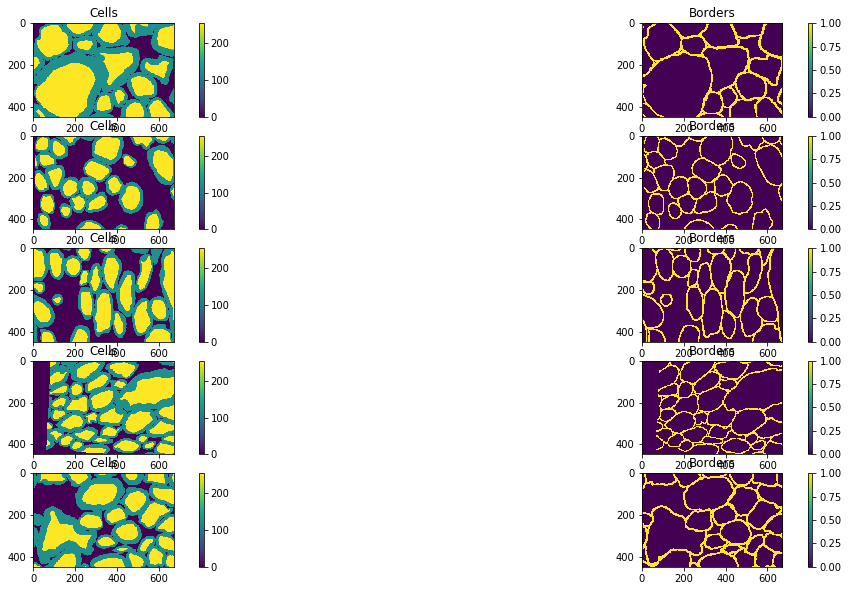

In [9]:
plt.figure(figsize=(20,10))
masks = [Y[:,:,:,0],Y[:,:,:,1]]
titles = ["Cells","Borders"]
visualization.compare_images(masks ,titles,5,True)

In [11]:
def extract_cellsA(mask):
    cells = np.zeros((mask.shape[0],IMG_SIZE_Y,IMG_SIZE_X,2))
    cells[:,:,:,0] = np.where(mask[:,:,:,0] > 120,250,0)
    cells[:,:,:,1] = 1 - cells[:,:,:,0]
    return cells

def extract_cells(mask):
    cells = np.zeros((mask.shape[0],IMG_SIZE_Y,IMG_SIZE_X,3))
    cells[:,:,:,0] = np.logical_and(mask[:,:,:,0] > 100, mask[:,:,:,0] < 200)
    cells[:,:,:,1] = mask[:,:,:,0] >= 200
    cells[:,:,:,2] = 1 - ( mask[:,:,:,0] > 100)
    return cells

def extract_sheaths_A(mask):
    sheaths = np.zeros((mask.shape[0],IMG_SIZE_Y,IMG_SIZE_X,2))
    sheaths[:,:,:,0] = mask[:,:,:,0]
    sheaths[:,:,:,1] = mask[:,:,:,2]
    return sheaths

def extract_sheaths(mask,threshold=120):
    sheaths = np.zeros((mask.shape[0],IMG_SIZE_Y,IMG_SIZE_X,2))
    sheaths[:,:,:,0] = mask[:,:,:,1]
    #sheaths[:,:,:,0] = np.logical_or(mask[:,:,:,1] < 120, mask[:,:,:,1] > 230)
    
    sheaths[:,:,:,1] = 1 - sheaths[:,:,:,0]
    return sheaths

In [12]:
train_size = 51
test_size = 19
valid_size = 3

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)
#X_test,X_valid,Y_test,Y_valid = train_test_split(X_test,Y_test,test_size=0.1,random_state=42)

#train
Y_train_cell = extract_cells(Y_train)
Y_train_border = extract_sheaths(Y_train)

#test
Y_test_cell = extract_cells(Y_test)
Y_test_border = extract_sheaths(Y_test)

#valid
#Y_valid_cell = extract_cells(Y_valid)
#Y_valid_border = extract_sheaths(Y_valid)

# making sure splitting went well
assert X_train.shape[:-1] == Y_train_cell.shape[:-1] == Y_train_border.shape[:-1]
assert X_test.shape[:-1] == Y_test_cell.shape[:-1] == Y_test_border.shape[:-1]
#assert X_valid.shape[:-1] == Y_valid_cell.shape[:-1] == Y_valid_border.shape[:-1]

print(f"Training with {X_train.shape[0]} elements")
print(f"Testing with {X_test.shape[0]} elements")
#print(f"Validating with {X_valid.shape[0]} elements")

Training with 70 elements
Testing with 30 elements


In [13]:
Y_train_cell.shape

(70, 448, 672, 3)

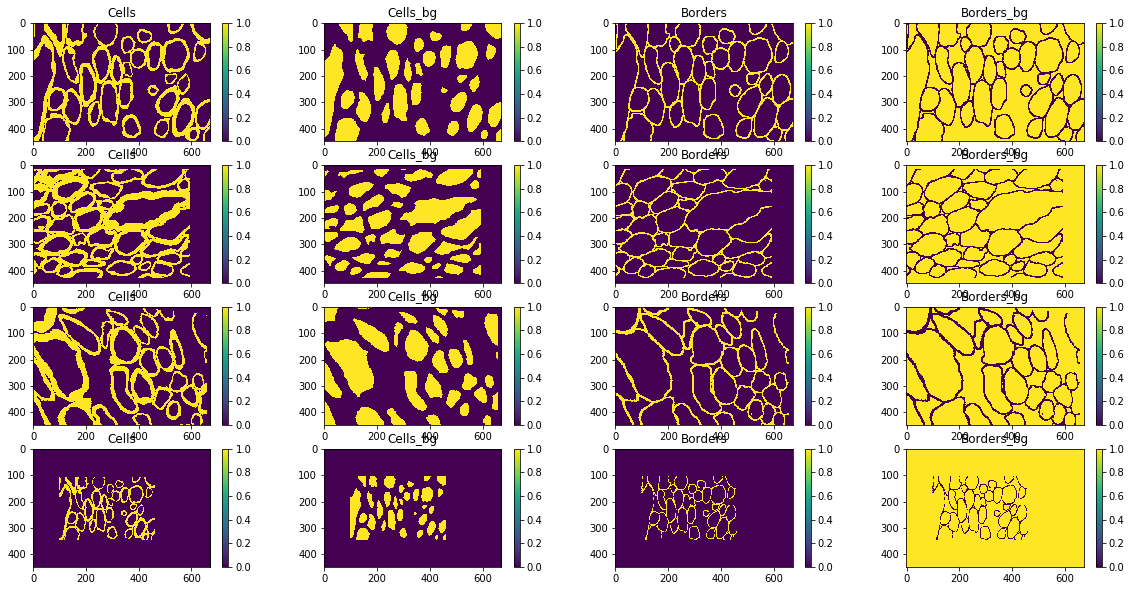

In [14]:
plt.figure(figsize=(20,10))
masks = [
    Y_train_cell[:,:,:,0],Y_train_cell[:,:,:,1],
    Y_train_border[:,:,:,0],Y_train_border[:,:,:,1]
]
titles = ["Cells","Cells_bg","Borders","Borders_bg"]
#titles = ["Borders","Borders_bg"]

visualization.compare_images(masks ,titles,4,True)

In [15]:
preprocess_input = sm.get_preprocessing("seresnet50")

X_train = processing.normalize(preprocess_input(X_train),norm=1.0)
X_test = processing.normalize(preprocess_input(X_test),norm=1.0)
#X_valid = processing.normalize(preprocess_input(X_valid),norm=1.0)

Y_train_cell = processing.normalize(np.float32(Y_train_cell),norm=1.0)
Y_train_border = processing.normalize(np.float32(Y_train_border),norm=1.0)

Y_test_cell = processing.normalize(np.float32(Y_test_cell),norm=1.0)
Y_test_border = processing.normalize(np.float32(Y_test_border),norm=1.0)

#Y_valid_cell = processing.normalize(np.float32(Y_valid_cell),norm=1.0)
#Y_valid_border = processing.normalize(np.float32(Y_valid_border),norm=1.0)

In [16]:
print(X_train.shape)
print(Y_train_cell.shape)
print(Y_train_border.shape)

(70, 448, 672, 3)
(70, 448, 672, 3)
(70, 448, 672, 2)


In [17]:
#PARAMETERS

activation = "softmax"
#metrics = [dice_coef]
training_metrics = [
    sm.metrics.IOUScore(threshold=0.5),
    sm.metrics.FScore(threshold=0.5),
    sm.metrics.Precision(),
    sm.metrics.Recall(),
    metrics.dice_coef
]

lr = 0.0001
epochs = 50

## BORDER
border_loss = metrics.surface_loss_keras
## CELL
cell_loss = sm.losses.jaccard_loss
n_classes = 2

In [18]:
def get_callbacks(filepath):
    checkpoints =  ModelCheckpoint(
        filepath,
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min'
    )
    return [
            tensorflow.keras.callbacks.ReduceLROnPlateau(),
            #checkpoints
        ]

border_filepath = './models/model-border-ep{epoch:03d}.h5'
cell_filepath = './models/model-cell-ep{epoch:03d}.h5'

border_callbacks = get_callbacks(border_filepath)
cell_callbacks = get_callbacks(cell_filepath)

# CELL

In [19]:
model_cell = sm.Unet(
    #"seresnet50",
    classes=3,
    activation=activation,
    decoder_use_batchnorm=True,
    input_shape=(IMG_SIZE_Y,IMG_SIZE_X,3),
    #encoder_weights='imagenet'
)

model_cell.compile(
    tf.keras.optimizers.Adam(lr=lr),
    loss=cell_loss,
    metrics=training_metrics,
)

In [ ]:
cell_history = model_cell.fit(
   x=X_train,
   y=Y_train_cell,
   batch_size=3,
   epochs=50,
   callbacks=cell_callbacks,
   validation_data=(X_test, Y_test_cell),
)

Train on 70 samples, validate on 30 samples
Epoch 1/50
70/70 [==============================] - 28s 397ms/sample - loss: 0.7397 - iou_score: 0.2622 - f1-score: 0.3786 - precision: 0.4338 - recall: 0.4422 - dice_coef: 0.4199 - val_loss: 0.8382 - val_iou_score: 0.1419 - val_f1-score: 0.2207 - val_precision: 0.5384 - val_recall: 0.3796 - val_dice_coef: 0.3710
Epoch 2/50
70/70 [==============================] - 11s 155ms/sample - loss: 0.6080 - iou_score: 0.5026 - f1-score: 0.6499 - precision: 0.5735 - recall: 0.5854 - dice_coef: 0.5624 - val_loss: 0.7725 - val_iou_score: 0.1827 - val_f1-score: 0.2743 - val_precision: 0.5962 - val_recall: 0.4392 - val_dice_coef: 0.4346
Epoch 3/50
70/70 [==============================] - 11s 156ms/sample - loss: 0.5212 - iou_score: 0.5952 - f1-score: 0.7367 - precision: 0.6559 - recall: 0.6723 - dice_coef: 0.6483 - val_loss: 0.6465 - val_iou_score: 0.3468 - val_f1-score: 0.4703 - val_precision: 0.6222 - val_recall: 0.5593 - val_dice_coef: 0.5539
Epoch 4/50


Epoch 27/50
70/70 [==============================] - 11s 156ms/sample - loss: 0.1172 - iou_score: 0.8973 - f1-score: 0.9453 - precision: 0.9320 - recall: 0.9423 - dice_coef: 0.9415 - val_loss: 0.1856 - val_iou_score: 0.8225 - val_f1-score: 0.9015 - val_precision: 0.8968 - val_recall: 0.8972 - val_dice_coef: 0.9000
Epoch 28/50
70/70 [==============================] - 11s 156ms/sample - loss: 0.1123 - iou_score: 0.9004 - f1-score: 0.9471 - precision: 0.9358 - recall: 0.9441 - dice_coef: 0.9436 - val_loss: 0.2067 - val_iou_score: 0.8004 - val_f1-score: 0.8882 - val_precision: 0.8857 - val_recall: 0.8835 - val_dice_coef: 0.8865
Epoch 29/50
70/70 [==============================] - 11s 156ms/sample - loss: 0.1102 - iou_score: 0.9016 - f1-score: 0.9477 - precision: 0.9377 - recall: 0.9445 - dice_coef: 0.9448 - val_loss: 0.1779 - val_iou_score: 0.8287 - val_f1-score: 0.9054 - val_precision: 0.9016 - val_recall: 0.9018 - val_dice_coef: 0.9041
Epoch 30/50
70/70 [==============================] -

In [30]:
model_cell.save_weights('./models/model_cell.h5')

In [29]:
Y_pred_cell = model_cell.predict(X_valid)

NameError: name 'X_valid' is not defined

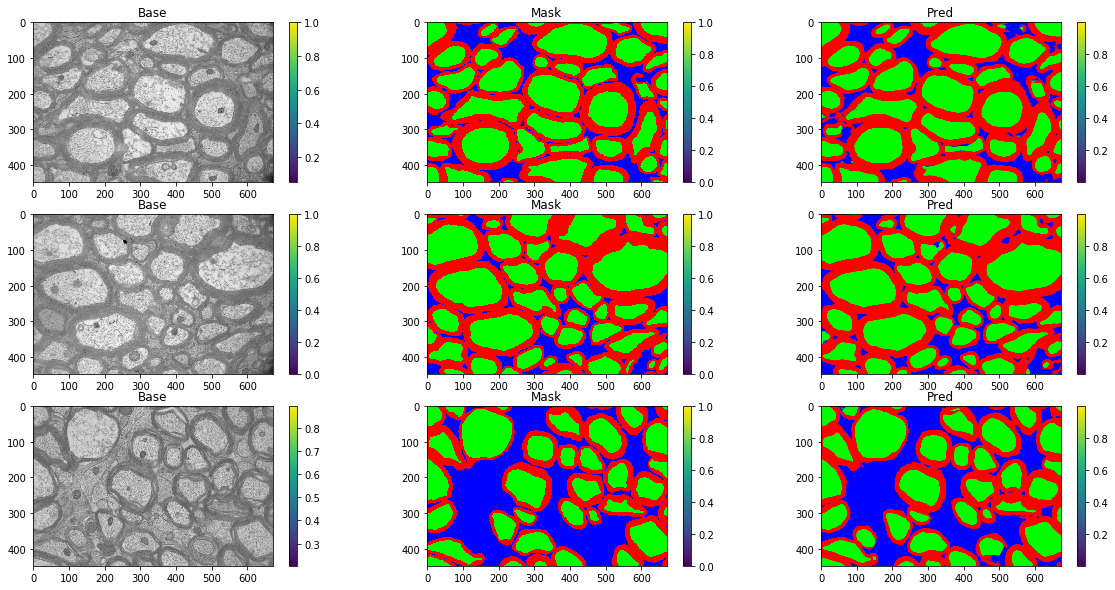

In [180]:
plt.figure(figsize=(20,10))
#images = [X_valid,Y_valid_cell[:,:,:,0],Y_pred_cell[:,:,:,0]]
images = [X_valid,Y_valid_cell,Y_pred_cell]
visualization.compare_images(images,["Base","Mask","Pred"],3,True)

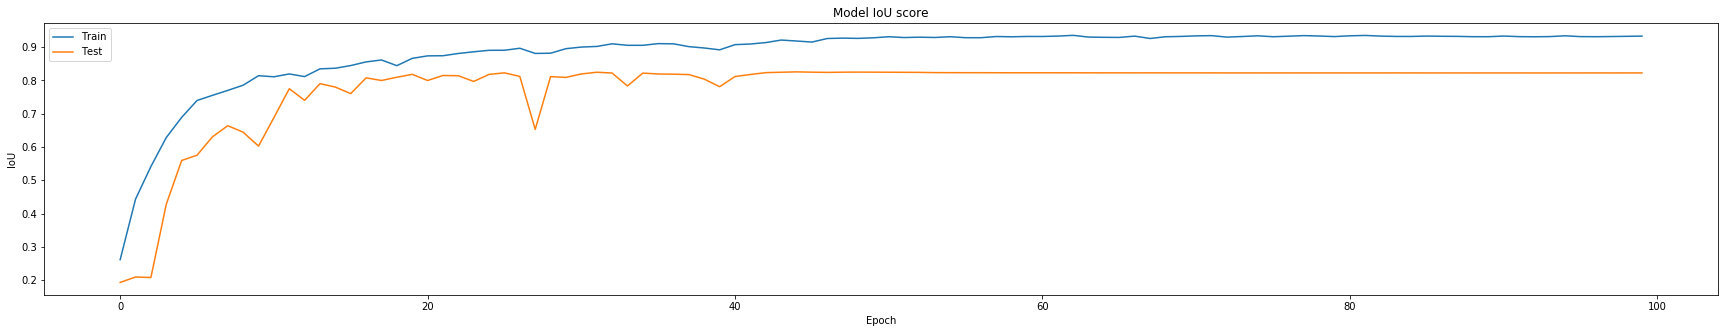

In [181]:
plt.figure(figsize=(30, 5))

metrics.plot_training_metrics(
    cell_history.history['iou_score'],
    cell_history.history['val_iou_score'],
    "IoU"
)

In [182]:
Y_pred_cell = Y_pred_cell.astype("float64")
valid_cell_dice = precision_m(Y_pred_cell[:,:,:,2],Y_valid_cell[:,:,:,2])
print(f"Cell validation dice coef : {valid_cell_dice:.3f}")

NameError: name 'precision_m' is not defined

# BORDER

In [32]:
model_border = sm.Unet(
    classes=2,
    activation="softmax",
    decoder_use_batchnorm=True,
    input_shape=(IMG_SIZE_Y,IMG_SIZE_X,3),
    encoder_weights='imagenet'
)

model_border.compile(
    tf.keras.optimizers.Adam(lr=0.0005),
    loss=border_loss,
    metrics=training_metrics,
)

In [103]:
border_history = model_border.fit(
   x=X_train,
   y=Y_train_border,
   batch_size=3,
   epochs=50,
   callbacks=border_callbacks,
   validation_data=(X_test, Y_test_border),
)

Train on 51 samples, validate on 19 samples
Epoch 1/50
51/51 [==============================] - 23s 448ms/sample - loss: 0.1537 - iou_score: 0.5088 - f1-score: 0.6321 - precision: 0.5701 - recall: 0.5968 - dice_coef: 0.6927 - val_loss: 0.1332 - val_iou_score: 0.4892 - val_f1-score: 0.5854 - val_precision: 0.5592 - val_recall: 0.5656 - val_dice_coef: 0.7329
Epoch 2/50
51/51 [==============================] - 20s 392ms/sample - loss: 0.0943 - iou_score: 0.6307 - f1-score: 0.7504 - precision: 0.6764 - recall: 0.6955 - dice_coef: 0.8114 - val_loss: 0.1320 - val_iou_score: 0.5807 - val_f1-score: 0.6973 - val_precision: 0.5922 - val_recall: 0.6164 - val_dice_coef: 0.7359
Epoch 3/50
51/51 [==============================] - 20s 389ms/sample - loss: 0.0737 - iou_score: 0.6691 - f1-score: 0.7830 - precision: 0.7379 - recall: 0.7277 - dice_coef: 0.8527 - val_loss: 0.1262 - val_iou_score: 0.5966 - val_f1-score: 0.7138 - val_precision: 0.6048 - val_recall: 0.6301 - val_dice_coef: 0.7476
Epoch 4/50


Epoch 27/50
51/51 [==============================] - 20s 401ms/sample - loss: 0.0192 - iou_score: 0.8814 - f1-score: 0.9352 - precision: 0.9325 - recall: 0.9306 - dice_coef: 0.9616 - val_loss: 0.0386 - val_iou_score: 0.7730 - val_f1-score: 0.8643 - val_precision: 0.8732 - val_recall: 0.8510 - val_dice_coef: 0.9222
Epoch 28/50
51/51 [==============================] - 20s 395ms/sample - loss: 0.0177 - iou_score: 0.8907 - f1-score: 0.9406 - precision: 0.9370 - recall: 0.9372 - dice_coef: 0.9645 - val_loss: 0.0382 - val_iou_score: 0.7756 - val_f1-score: 0.8662 - val_precision: 0.8749 - val_recall: 0.8538 - val_dice_coef: 0.9234
Epoch 29/50
51/51 [==============================] - 20s 401ms/sample - loss: 0.0176 - iou_score: 0.8912 - f1-score: 0.9410 - precision: 0.9379 - recall: 0.9372 - dice_coef: 0.9649 - val_loss: 0.0385 - val_iou_score: 0.7709 - val_f1-score: 0.8627 - val_precision: 0.8775 - val_recall: 0.8457 - val_dice_coef: 0.9225
Epoch 30/50
51/51 [==============================] -

In [112]:
model_border.save_weights('./models/model_border.h5')

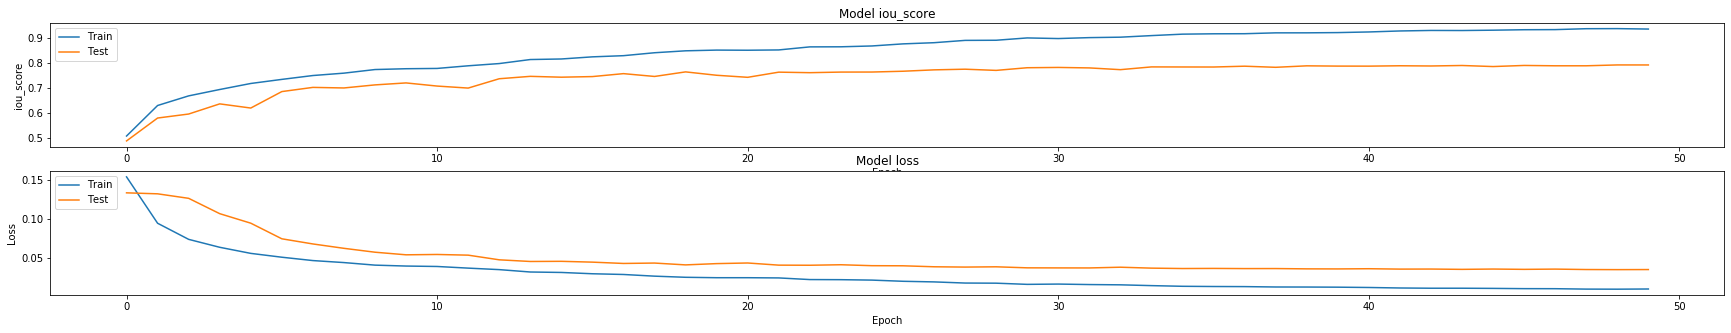

In [108]:
plt.figure(figsize=(30, 5))
plt.subplot(211)
plt.plot(border_history.history['iou_score'])
plt.plot(border_history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(212)
plt.plot(border_history.history['loss'])
plt.plot(border_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [90]:
def max_chan_filter(img):
	border,bg = img[:,:,:,0],img[:,:,:,1]
	M = np.maximum(border,bg)
	border[border < M] = 0
	return border

(3, 448, 672, 2)
(3, 448, 672)


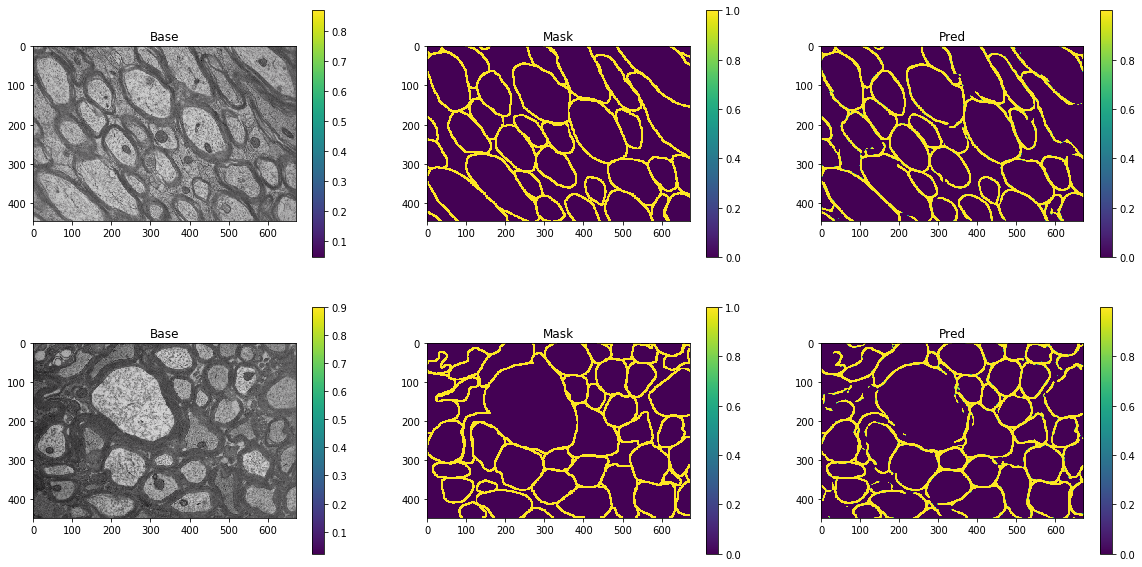

In [109]:
Y_pred_border = model_border.predict(X_valid)
print(Y_pred_border.shape)
Y_pred_border = max_chan_filter(Y_pred_border)
print(Y_pred_border.shape)
#Y_pred_border = processing.normalize(Y_pred_border,1.0)
#Y_pred_border[:,:,:,0] = apply_dilatation(Y_pred_border[:,:,:,0],thickness=(3,3),iterations=2)
#Y_pred_border = (Y_pred_border > 0.4).astype("float64")
plt.figure(figsize=(20,10))
images = [X_valid,Y_valid_border[:,:,:,0],Y_pred_border]

visualization.compare_images(images,["Base","Mask","Pred"],2,True)

In [111]:
Y_pred_border = model_border.predict(X_valid)
Y_pred_border = Y_pred_border.astype("float64")
valid_cell_border = precision_m(Y_pred_border[:,:,:,0],Y_pred_border[:,:,:,0])
print(f"Cell validation dice coef : {valid_cell_border:.3f}")

Cell validation dice coef : 0.973


# Combining both

In [47]:
model_cell.load_weights('./models/model_cell.h5')
model_border.load_weights('./models/model_border.h5')

In [164]:
Y_pred_cell = model_cell.predict(X_valid)
Y_pred_border = model_border.predict(X_valid)

# add a 3rd layer full of zero to plot
#Y_pred_border = processing.raise_to_three_layers(Y_pred_border,fill_with=1)
#Y_pred_border[:,:,:,2] = Y_pred_cell[:,:,:,2]

In [165]:
def generate_final(cells,borders):
    res = np.zeros((Y_pred_cell.shape[0],IMG_SIZE_Y,IMG_SIZE_X))
    if cells.shape != borders.shape:
        print(f"Shape error cells {cells.shape} and border {borders.shape} must have same shape")
        return
    
    for img_id in range(cells.shape[0]):
        for x in range(cells.shape[1]):
            for y in range(cells.shape[2]):
                res[img_id,x,y] = (cells[img_id,x,y] == 1) and (borders[img_id,x,y] == 0)

    return res

def add_background(X):
    h = X.shape[1]
    w = X.shape[2]
    res = np.zeros((X.shape[0],h,w,3))
    res[:,:,:,0] = X[:,:,:,0]
    res[:,:,:,1] = X[:,:,:,1]
    res[:,:,:,2] = res[:,:,:,2] = np.ones((h,w))
    res[:,:,:,2] -= X[:,:,:,0]
    res[:,:,:,2] -= X[:,:,:,1]
    res[:,:,:,2] = np.where(res[:,:,:,2] < 0, 0, res[:,:,:,2])
    
    return res

In [166]:
Y_pred_final = np.zeros((Y_pred_cell.shape[0],IMG_SIZE_Y,IMG_SIZE_X,2))
#Y_pred_final[:,:,:,0] = Y_pred_border[:,:,:,0]
#Y_pred_final[:,:,:,1] = Y_pred_cell[:,:,:,0]
Y_pred_border[:,:,:,0] = (Y_pred_border[:,:,:,0] > 0.9)
Y_pred_cell[:,:,:,0] = (Y_pred_cell[:,:,:,0] > 0.5)

#Y_pred_final[:,:,:,0] = np.logical_and(Y_pred_cell[:,:,:,0],Y_pred_border[:,:,:,0])
Y_pred_final[:,:,:,0] = generate_final(Y_pred_cell[:,:,:,0],Y_pred_border[:,:,:,0])
Y_pred_final[:,:,:,1] = Y_pred_cell[:,:,:,1]
Y_pred_final = add_background(Y_pred_final)

In [118]:
for img_id in range(len(Y_pred_final)):
    img = Y_pred_final[img_id]
    img = img[...,::-1]
    img = np.expand_dims(img,axis=0)
    img = processing.normalize(img,255)
    res = cv2.imwrite(f"./KERAS/Exports/{img_id}_export.png",img.squeeze())
    if res:
        print(f"Image {img_id}_export.png saved")

Image 0_export.png saved
Image 1_export.png saved
Image 2_export.png saved


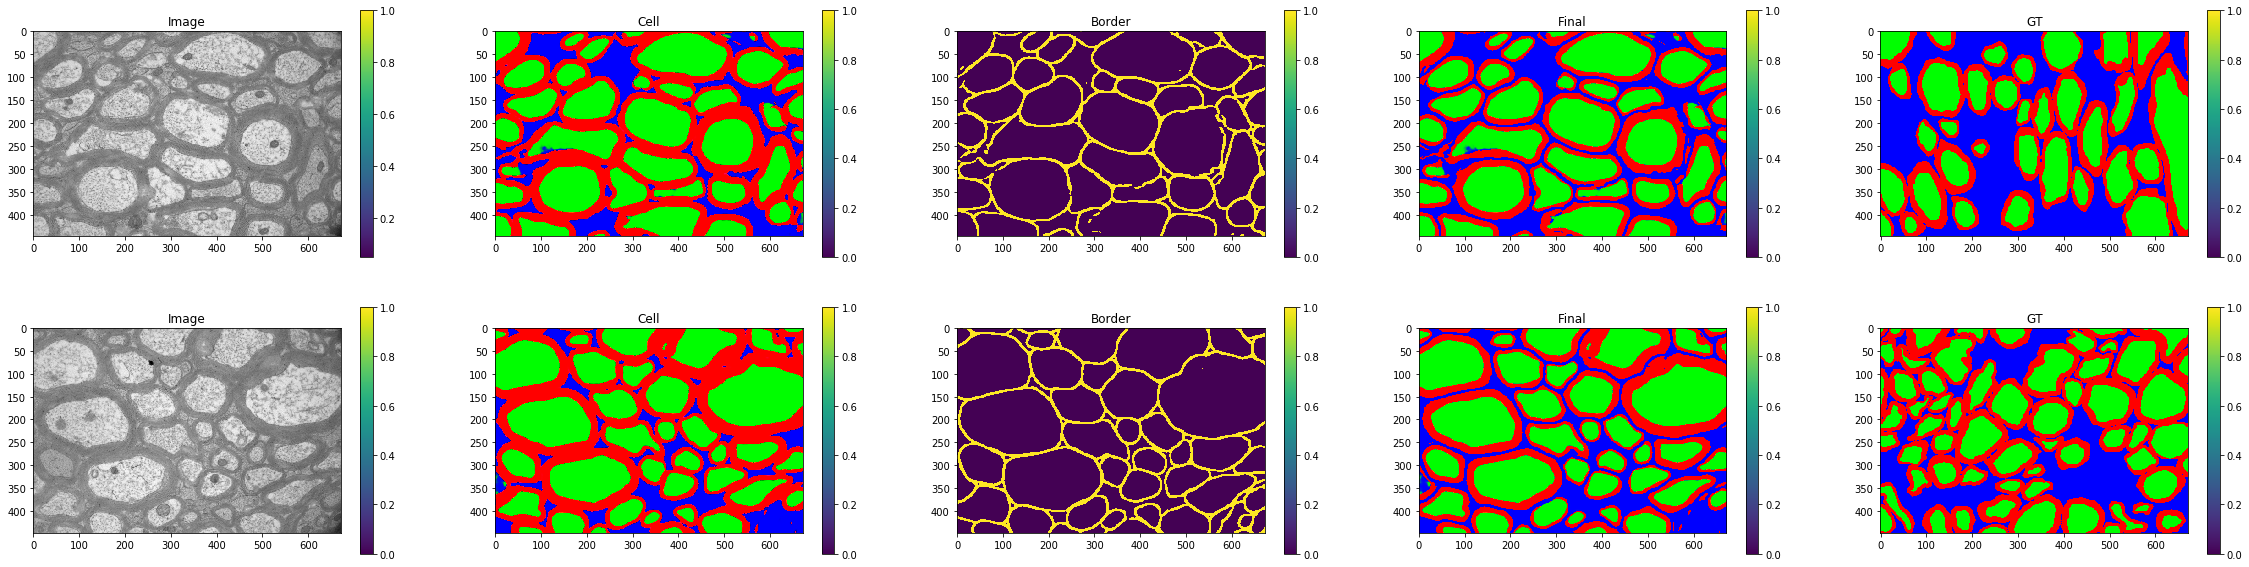

In [167]:
plt.figure(figsize=(40,10))
masks = [X_valid,Y_pred_cell,Y_pred_border[:,:,:,0],Y_pred_final,Y_valid_cell]
#masks = [Y_pred_final,Y_valid]
titles = ["Image","Cell","Border","Final","GT"]
#titles = ["Final","GT"]
visualization.compare_images(masks ,titles,2,True)

In [77]:
#Y_valid = Y_valid.astype("float64")
sheath_diff = dice_coef(Y_pred_final[:,:,:,0],Y_valid_final[:,:,:,0])
cell_diff = dice_coef(Y_pred_final[:,:,:,1],Y_valid_final[:,:,:,1])
bg_diff = dice_coef(Y_pred_final[:,:,:,2],Y_valid_final[:,:,:,2])

total_diff = dice_coef(Y_pred_final,Y_valid_cell)
#border_diff = dice_coef(Y_valid_bin[:,:,:,2],Y_pred_final[:,:,:,2])
#total_dice  = dice_coef(Y_valid_bin,Y_pred_final)
print(f"Sheath dice {sheath_diff}")
print(f"Cell dice {cell_diff}")
print(f"Mean Sheath/Cell dice {(sheath_diff+cell_diff)/2}")
print(f"Bg dice {bg_diff}")
print(f"Total dice {total_diff}")

NameError: name 'Y_valid_final' is not defined

In [90]:
def pred_final(x):
    pred_cell = model_cell.predict(x)
    pred_border = model_border.predict(x)
    pred_border = processing.raise_to_three_layers(pred_border)
    return np.multiply(pred_cell,pred_border)

def add_background(X):
    h = X.shape[1]
    w = X.shape[2]
    res = np.zeros((X.shape[0],h,w,3))
    res[:,:,:,0] = X[:,:,:,0]
    res[:,:,:,1] = X[:,:,:,1]
    res[:,:,:,2] = res[:,:,:,2] = np.ones((h,w))
    res[:,:,:,2] -= X[:,:,:,0]
    res[:,:,:,2] -= X[:,:,:,1]
    res[:,:,:,2] = np.where(res[:,:,:,2] < 0, 0, res[:,:,:,2])
    
    return res

In [34]:
def apply_erosion(x,thickness=(5,5),iterations=1):
    res = np.zeros((x.shape)).astype("float32")
    for img_idx in range(x.shape[0]):
        res[img_idx,:,:] = cv2.erode(x[img_idx,:,:],thickness,iterations = iterations)
    return res

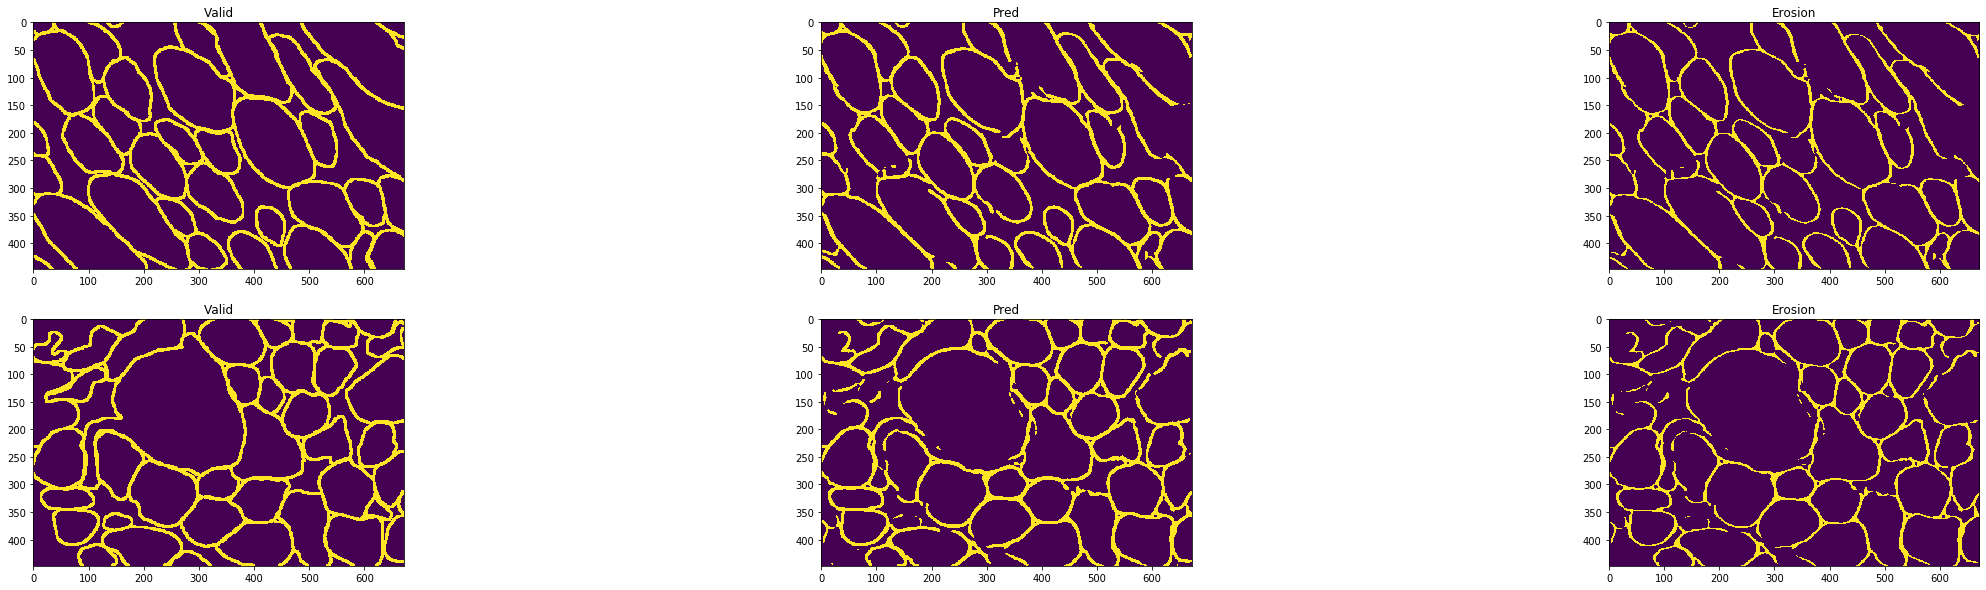

In [126]:
plt.figure(figsize=(40,10))
kernel = np.ones((5,5),np.uint8)
erosion = apply_erosion(Y_pred_border[:,:,:,0],(5,5),3)

masks = [Y_valid_border[:,:,:,0],Y_pred_border[:,:,:,0],erosion]
titles = ["Valid","Pred","Erosion"]
visualization.compare_images(masks,titles)

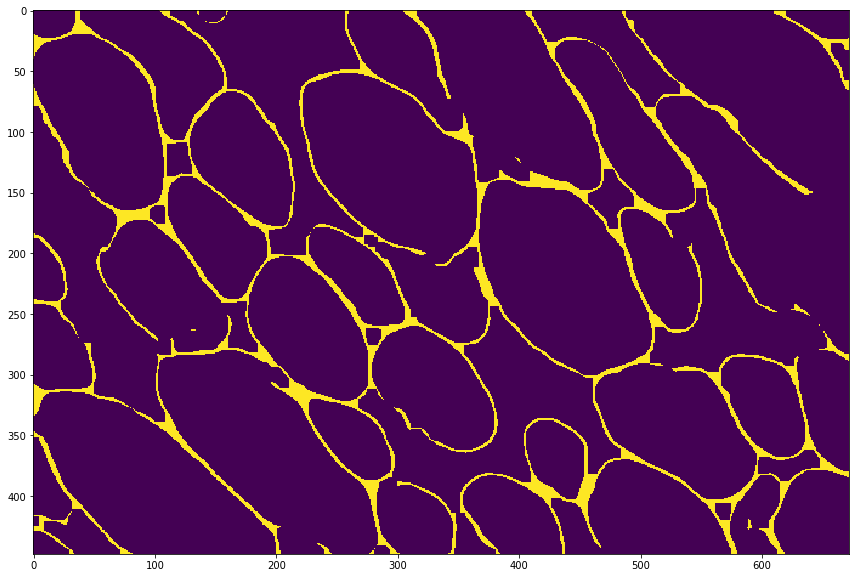

In [127]:
plt.figure(figsize=(40,10))
kernel = np.ones((5,5),np.uint8)
eroded = cv2.morphologyEx(Y_pred_border[0,:,:,0], cv2.MORPH_CLOSE, kernel)
eroded = cv2.erode(eroded,np.ones((4,4),np.uint8),iterations = 1)
plt.imshow(eroded)

# Dilatation

# Tests 

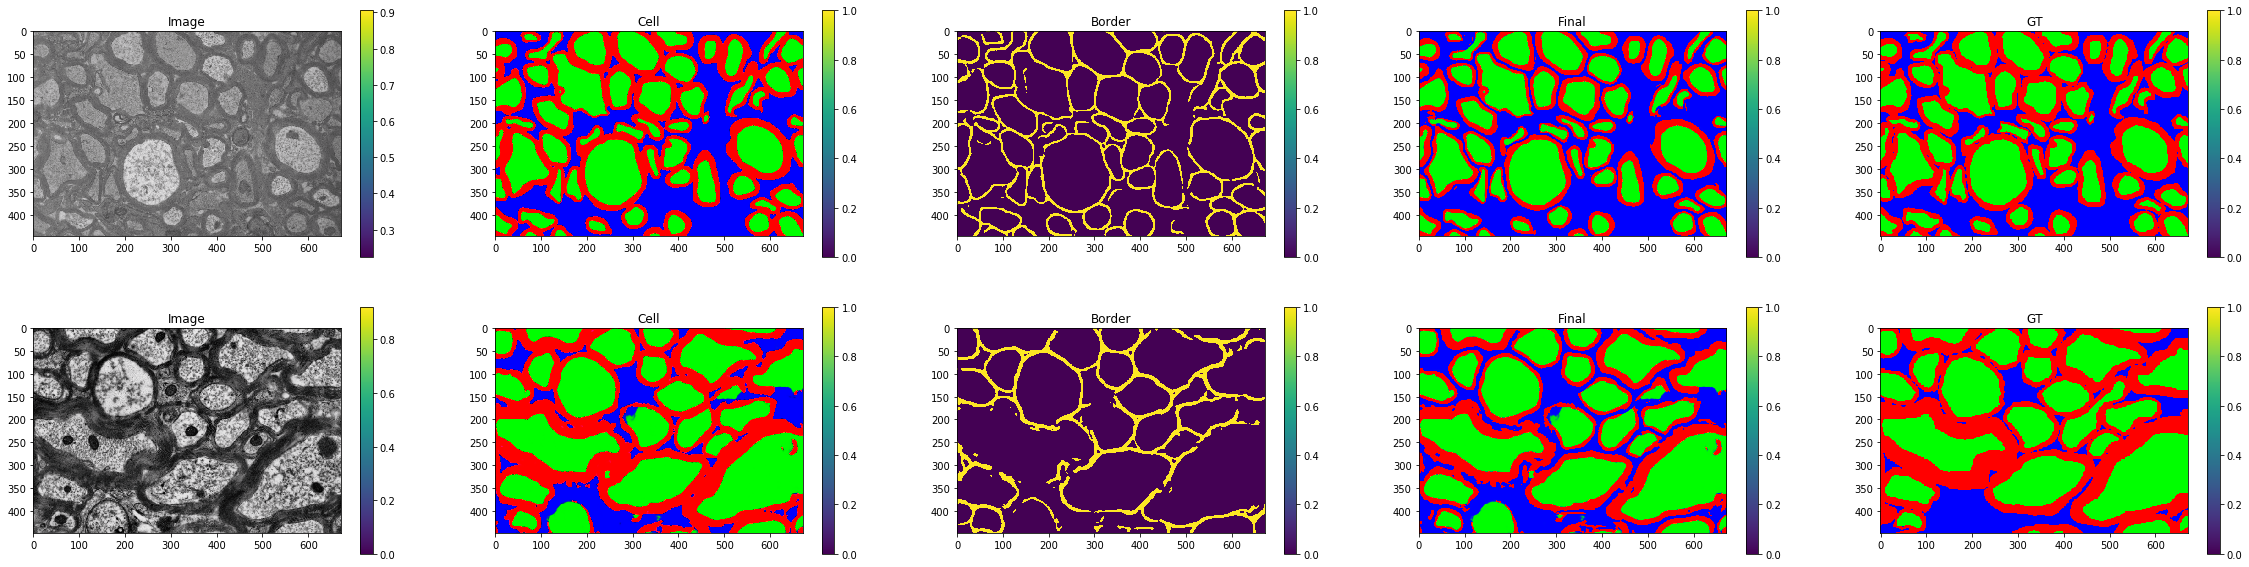

In [76]:
plt.figure(figsize=(40,10))
masks = [X_valid,Y_pred_cell,Y_pred_border[:,:,:,0],Y_pred_final,Y_valid_cell]
#masks = [Y_pred_final,Y_valid]
titles = ["Image","Cell","Border","Final","GT"]
#titles = ["Final","GT"]
visualization.compare_images(masks ,titles,2,True)

In [25]:
img = cv2.imread(image_path+"HPF4-416S1-3A-6500x-4_segmented_EXT.png",1)
img.shape

(888, 1336, 3)

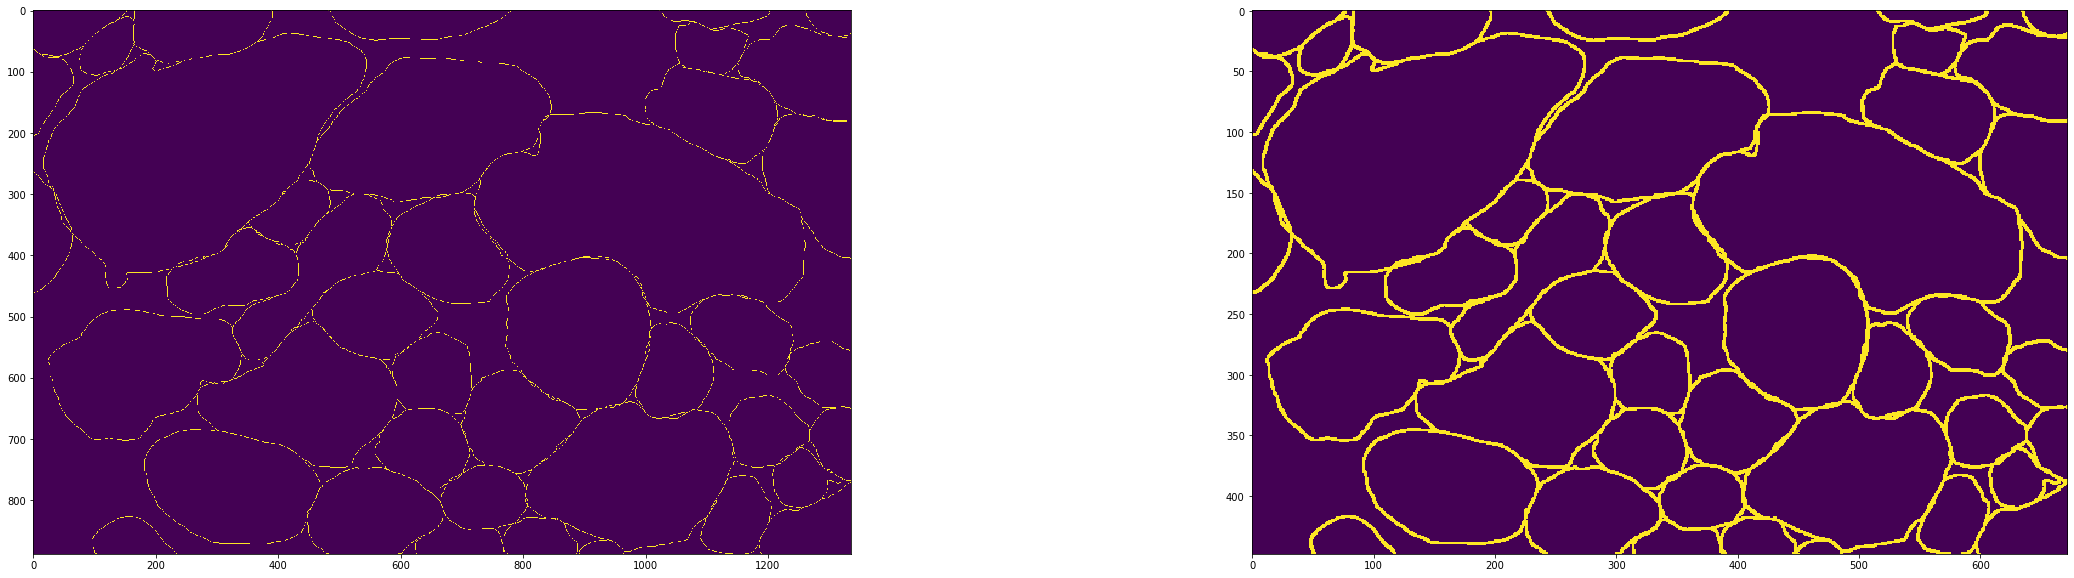

In [40]:
plt.figure(figsize=(40,10))
test = (img[:,:,1] < 120).astype("float32")
kernel = np.ones((3,3),np.uint8)
test = cv2.dilate(test,kernel,iterations = 2)
test = cv2.resize(test,(DESIRED_SHAPE))
test = (test > 0.5).astype("float32")
#test = cv2.morphologyEx(test, cv2.MORPH_CLOSE, (5,5))#cv2.dilate(test,(10,10),iterations = 1)
#test = cv2.dilate(test,(40,40),iterations = 5)
#test = cv2.morphologyEx(test, cv2.MORPH_CLOSE, (15,15))
#test = cv2.dilate(test,(40,40),iterations = 5)
plt.subplot(1,2,1)
plt.imshow((img[:,:,1] < 120).astype("float32"))
plt.subplot(1,2,2)
plt.imshow(test)
plt.show()

# Prediction

In [33]:
model_cell.load_weights('./models/model_cell.h5')
model_border.load_weights('./models/model_border.h5')

In [34]:
valid_images = ["HPF4-416S1-3A-6500x-8","HPF4-416S1-3A-6500x-9","HPF4-416S2-5B-6500x-6"]
X_valid,Y_cell,Y_border = processing.load_specific_images(
    image_path,valid_images,shape=DESIRED_SHAPE,dilatation = (4,4,3)
)
X_valid = processing.normalize(X_valid,norm = 255,data_type=np.uint8)
Y_cell = processing.normalize(Y_cell,norm = 255,data_type=np.uint8)
Y_border = processing.normalize(Y_border,norm = 255,data_type=np.uint8)

Y_valid = np.stack((Y_cell[:,:,:,1],Y_border[:,:,:,0]),axis=3)
Y_valid[:,:,:,1] = (Y_valid[:,:,:,1] > 125).astype("float32")
print(Y.shape)

(100, 448, 672, 2)


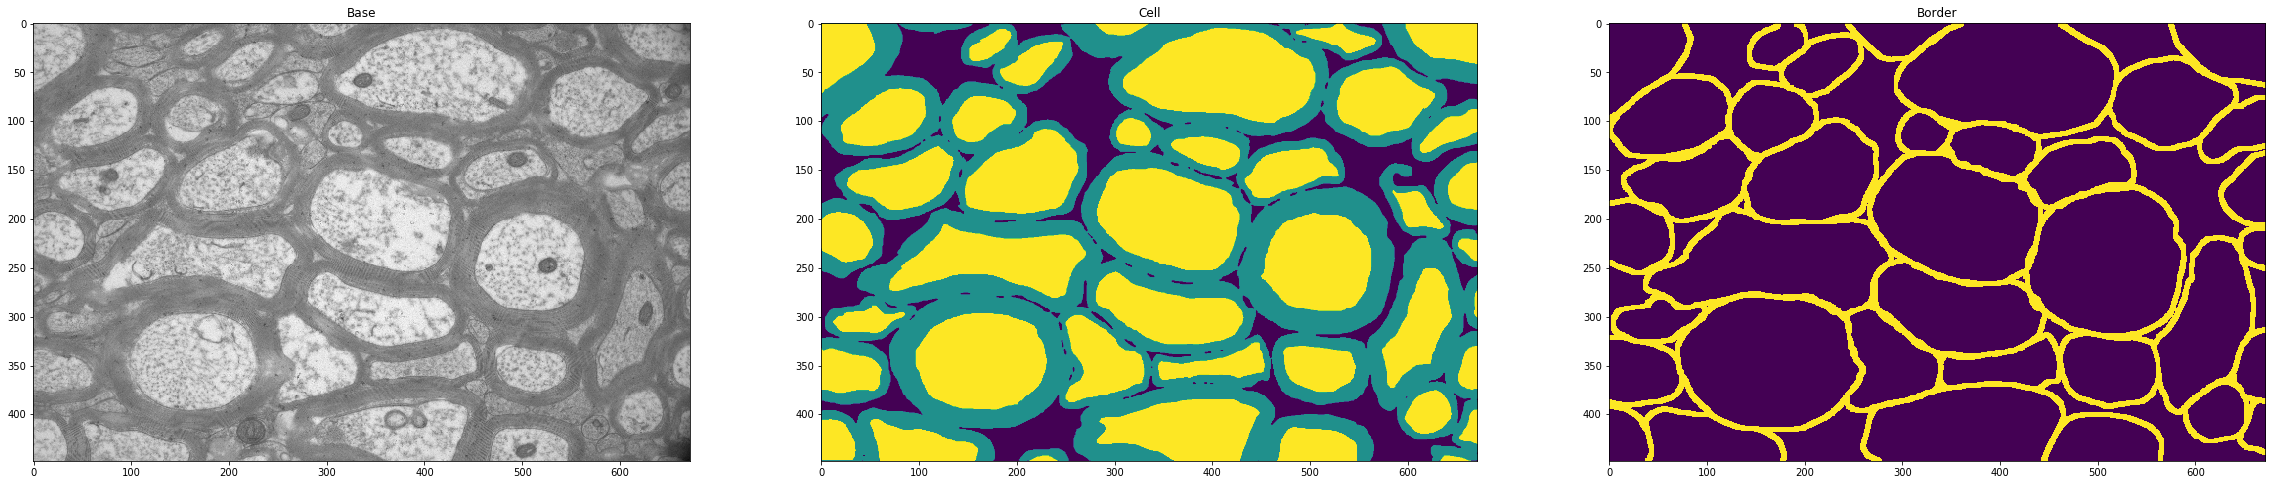

In [35]:
plt.figure(figsize=(40,10))
masks = [X_valid,Y_valid[:,:,:,0],Y_valid[:,:,:,1]]
titles = ["Base","Cell","Border"]
visualization.compare_images(masks ,titles,1,False)

In [36]:
Y_valid_cell = extract_cells(Y_valid)
Y_valid_border = extract_sheaths(Y_valid)

preprocess_input = sm.get_preprocessing("seresnet50")
X_valid = processing.normalize(np.float32(X_valid),norm=1.0)
Y_valid_cell = processing.normalize(np.float32(Y_valid_cell),norm=1.0)
Y_valid_border = processing.normalize(np.float32(Y_valid_border),norm=1.0)

In [37]:
Y_pred_cell = model_cell.predict(X_valid)
scores = [sm.metrics.Recall(),metrics.precision_m,metrics.dice_coef]
scores_name = ["Recall","Precision","Dice"]
layers = ["Myelin","Axon","Background"]
metrics.compute_results(scores,scores_name,layers,Y_valid_cell,Y_pred_cell)

           |Myelin     |Axon       |Background |
Recall     |     0.913 |     0.957 |     0.813 |
Precision  |     0.886 |     0.950 |     0.888 |
Dice       |     0.898 |     0.953 |     0.848 |


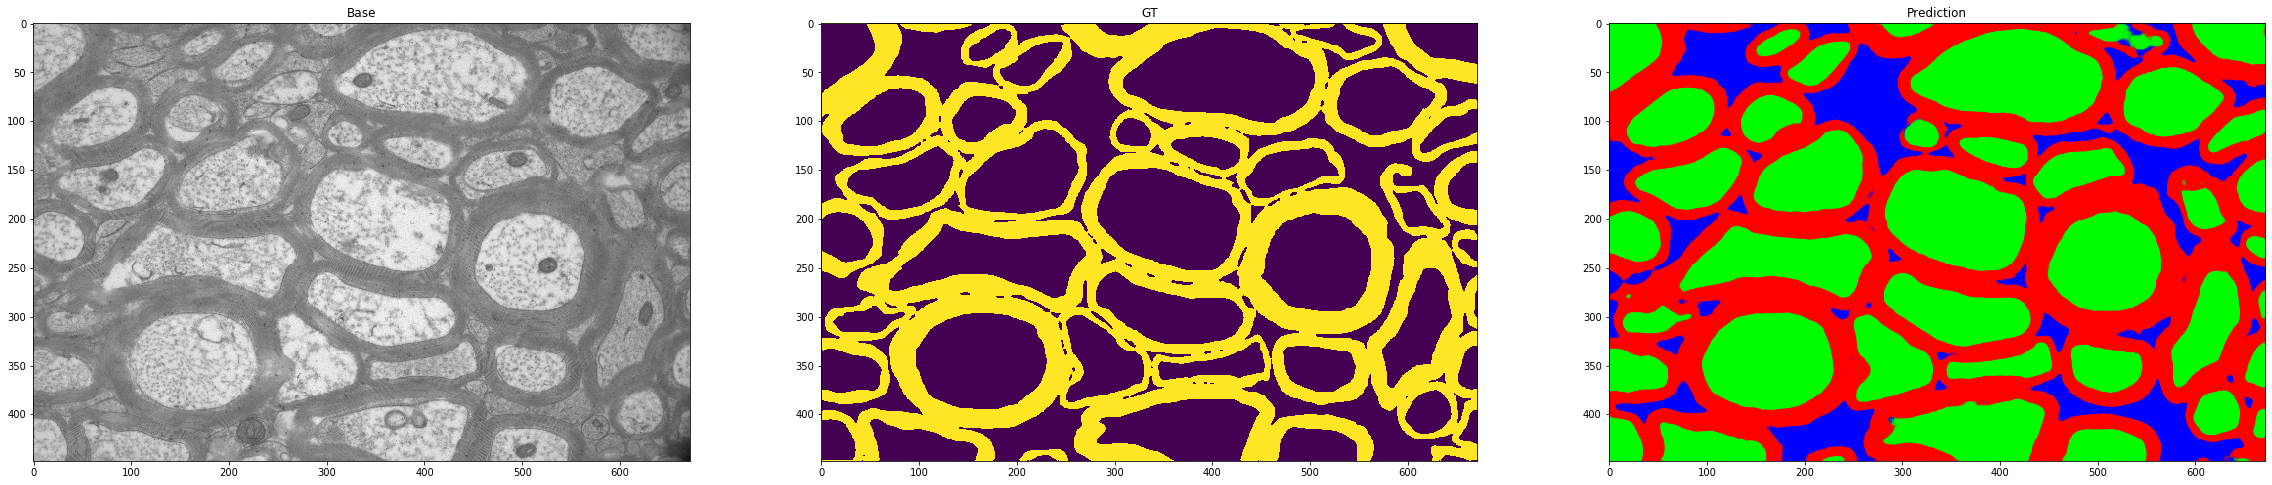

In [31]:
plt.figure(figsize=(40,10))
masks = [X_valid,Y_valid_cell[:,:,:,0],Y_pred_cell]
titles = ["Base","GT","Prediction"]
visualization.compare_images(masks ,titles,1,False)

# Combining border and grayscale

In [43]:
Y_pred_border = model_border.predict(X_valid)

In [118]:
z = np.zeros(((IMG_SIZE_Y,IMG_SIZE_X,1))).astype("float32")
gray = X_valid[0,:,:,0].astype("float32")
gray = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)
border = np.expand_dims(Y_pred_border[0,:,:,0].astype("float32"),axis=-1)

border = cv2.merge((border,z,z))
added_image = cv2.addWeighted(gray,.4,border,1.0,0).astype("float32")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


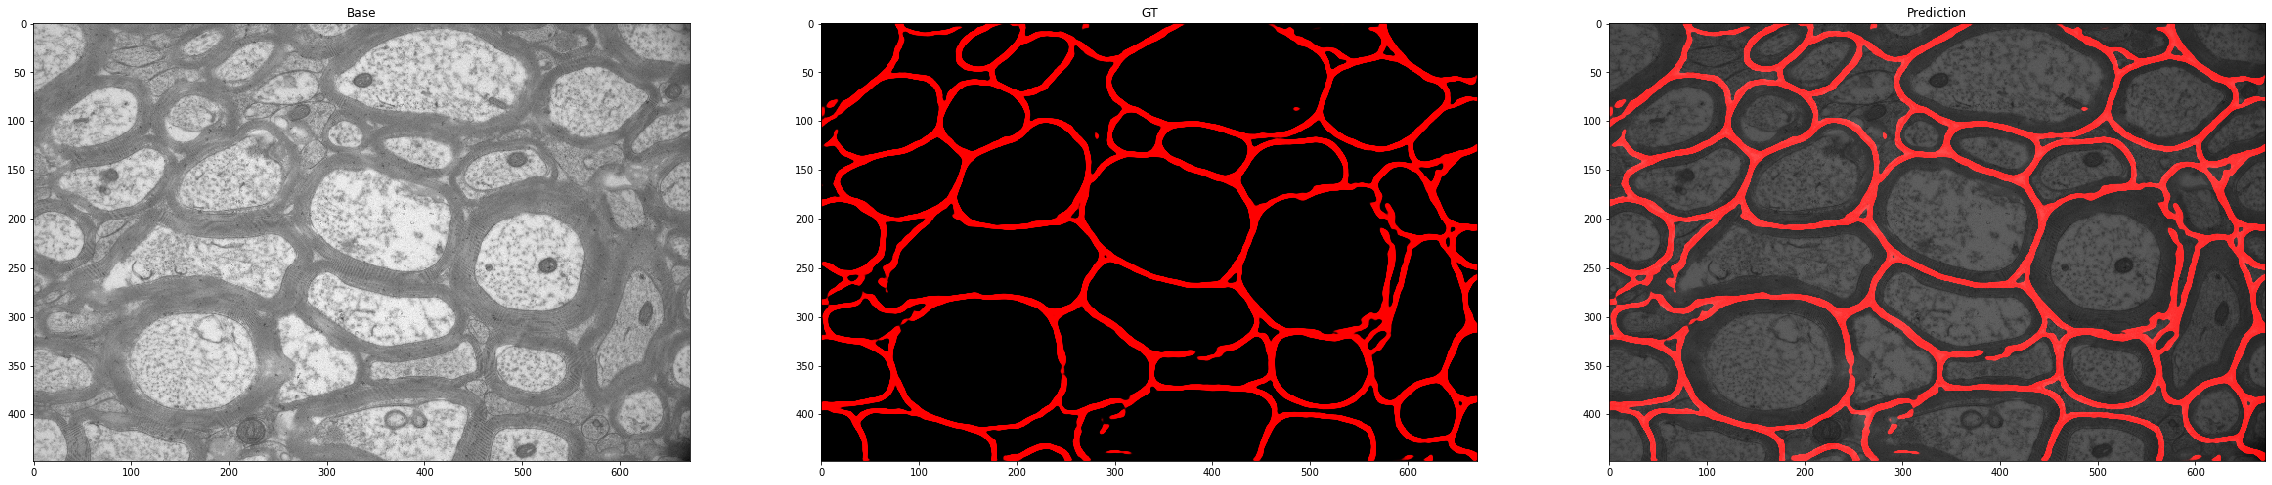

In [120]:
plt.figure(figsize=(40,10))
masks = [gray,border,added_image]
titles = ["Base","GT","Prediction"]
visualization.compare_images(masks ,titles,1,False)

In [97]:
border.shape

(448, 672, 1)